# Prompting LLMs

In this notebook, we explore:
  - Zero-shot prompting
  - Prompt engineering
  - Few-shot prompting
  - Prompting instruction-tuned models
  - Chain-of-Thought Reasoning prompting

## Dataset / Packages
- **Run the following cells and enter your OpenAI API Key!**

In [ ]:
%%capture
!pip install openai datasets

In [ ]:
from openai import OpenAI
from time import sleep
from datasets import load_dataset

IMDB_DATASET = load_dataset("imdb", split='train').shuffle(42)[0:200]
IMDB_DATASET_X = IMDB_DATASET['text']
IMDB_DATASET_Y = IMDB_DATASET['label']
del IMDB_DATASET

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from getpass import getpass
import os

print('Enter OpenAI API key:')
openai_api_key = getpass()

os.environ['OPENAI_API_KEY']=openai_api_key
client = OpenAI()

Enter OpenAI API key:
··········


In [ ]:
OPENAI_API_KEY = openai_api_key

In [ ]:
import openai

cache = {}
def run_gpt3(prompt, return_first_line = True, instruction_tuned = False):
    # Return the response from the cache if we have already run this
    cache_key = (prompt, return_first_line, instruction_tuned)
    if cache_key in cache:
        return cache[cache_key]

    response = ""

    # Select the model
    if instruction_tuned:
        model = "gpt-3.5-turbo-instruct"
    else:
        # You may also use "davinci-002"
        model = "babbage-002"

    # Send the prompt to GPT-3
    for i in range(0,60,6):
        try:
            response = client.completions.create(
                model=model,
                prompt=prompt,
                temperature=0,
                max_tokens=100,
                top_p=1,
                frequency_penalty=0.0,
                presence_penalty=0.0,
            ).choices[0].text.strip()
            break
        except openai.RateLimitError as e:
            print(e)
            sleep(i)

        except Exception as e:
            print(e)
            break

    # Parse the response
    if return_first_line:
        final_response = response.split('\n')[0]
    else:
        final_response = response

    # Cache and return the response
    cache[cache_key] = final_response
    return final_response

# Section 1: Exploring Prompting
**Background:** Prompting is a way to guide a language model, which is ultimately just a model that predicts the most likely next sequence of words, to complete some arbitrary task you want it to complete.

A language model will "complete" your prompt with what words are most likely to come next. We demonstrate this is the case by showing how GPT-3 completes movie quotes, when giving it the beginning of the quote:

In [ ]:
print(run_gpt3("Life is like a box of chocolates,"))
print(run_gpt3("With great power,"))
print(run_gpt3("The name's Bond."))
print(run_gpt3("Houston, we"))
print(run_gpt3("I've a feeling we're not in"))

you never know what you're gonna get. (laughing)
comes great responsibility. The same goes for the power of the internet. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool
James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James
have a problem.
Kansas anymore.


Now imagine we give a prompt like this:

In [ ]:
print(run_gpt3("Question: Who was the first president of the United States? Answer:"))

George Washington. The first president of the United States was George Washington. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of


By posing a question and writing "Answer:" at the end, we make it such that the most likely next sequence of words is the answer to the question! This is the key to large language models being able to perform arbitrary tasks, even though they are only trained to predict the next word.

We can parameterize this prompt and make it reusable for different questions:

In [ ]:
QA_PROMPT = "Question: {input} Answer:"
print(run_gpt3(QA_PROMPT.replace("{input}", "What company did Steve Jobs found?")))
# print(run_gpt3(QA_PROMPT.replace("{input}", "What's the movie with Tom Cruise about fighter jets?")))
# print(run_gpt3(QA_PROMPT.replace("{input}", "Are tomatoes a fruit or a vegetable?")))

Apple Inc. Steve Jobs founded Apple in 1976. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years.


Prompt that returns the capital of country.

In [ ]:
CAPITAL_OF_COUNTRY_PROMPT = "Country: {input} Capital:"

Prompt that given a word, returns a list of synonyms.

In [ ]:
SYNONYMS_OF_WORD_PROMPT = "Word: {input} Synonyms: "
# print(run_gpt3(SYNONYMS_OF_WORD_PROMPT.replace("{input}", "bug"), return_first_line=False))

Prompt Engineering

---

The prompts up to this point have been fairly basic and straightforward to create. But what if you have a more difficult task and it seems like your prompt isn't working? *Prompt engineering* is the procecss of iterating on a prompt in clever ways to induce the model to produce what you want. The best way of prompt engineering systematically vs. randomly is by understanding how the underlying model was trained and what data it was trained on to best prompt the model.

Imagine we want the model to generate a quote in Donald Trump's style of talking about a certain topic:

In [ ]:
DONALD_TRUMP_PROMPT = "Question: What would Donald Trump say about {input}? Answer:"
DONALD_TRUMP_PROMPT_ENGINEERED_1 = 'On the topic of {input}, Donald Trump was quoted as saying "'
DONALD_TRUMP_PROMPT_ENGINEERED_2 = 'On the topic of {input}, Donald Trump expressed optimism saying "'
DONALD_TRUMP_PROMPT_ENGINEERED_3 = 'On the topic of {input}, Donald Trump expressed doubt saying "'

print(run_gpt3(DONALD_TRUMP_PROMPT.replace("{input}", 'the stock market'))) # Doesn't work
print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_1.replace("{input}", 'the stock market'))) # Works!
# print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_2.replace("{input}", 'the stock market'))) # Works!
# print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_3.replace("{input}", 'the stock market'))) # Works!

He would say it’s a “great time to buy.”
I'm not a big fan of the stock market. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged. I think it's rigged


The first naive prompt doesn't really work. After prompt engineering, not only do we get a much more realistic generation of his style, but we can also control whether he is talking about the topic positively or negatively.

The engineered prompt, 'On the topic of {input}, Donald Trump was quoted as saying "', worked much better than the original "Question: What would Donald Trump say about {input}? Answer:" prompt because it is probably more similarly structured to how news was reported or how articles were written on the internet, which is what the underlying model was trained on. By prompting the model to complete a sentence with “Donald Trump was quotes as saying” with an open quotation, it induces the model to generate something in the style of an actual quote said by Trump.

A prompt that is well-engineered can effectively solve difficult NLP tasks that previously were solved by fine-tuning models.

Next, we will solve the [sentiment classification task](https://en.wikipedia.org/wiki/Sentiment_analysis), and classify [movie reviews](https://ai.stanford.edu/~amaas/data/sentiment/) as *positive* or *negative*. `IMDB_DATASET_X` and `IMDB_DATASET_Y` contain 200 reviews and sentiment labels (1 = positive, 0 = negative).

In [ ]:
MOVIE_SENTIMENT_PROMPT = "{input}. If I had to pick between 'good' or 'bad' I would say this movie is"

POSITIVE_VERBALIZERS = [
    "good",
    "fantastic",
    "great",
    "awesome",
    "terrific",
    "like",
    "better",
    "enjoy"
]
NEGATIVE_VERBALIZERS = [
    "bad",
    "boring",
    "terrible",
    "disappointed",
    "awful",
    "hate",
    "worse",
    "poor"
]

def map_to_sentiment_label(gpt3_output):
    for v in POSITIVE_VERBALIZERS:
        if v.lower() in gpt3_output[:20].lower():
            return 1
    for v in NEGATIVE_VERBALIZERS:
        if v.lower() in gpt3_output[:20].lower():
            return 0
    return None

correct = 0
for review, label in zip(IMDB_DATASET_X, IMDB_DATASET_Y):
    gpt3_output = run_gpt3(MOVIE_SENTIMENT_PROMPT.replace("{input}", review))
    prediction = map_to_sentiment_label(gpt3_output)
    if prediction == label:
        correct += 1
    print(f"Prediction: {prediction}, Label: {label}")
print(f"Correct: {correct}/200")

Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 1, Label: 0
Prediction: 0, Label: 1
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 0, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 1, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 1
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 0, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, L

# Few-Shot Prompting

The prompts you have seen up until this point are zero-shot prompts, in that we are asking the model to complete a task without any examples. By providing some examples in the prompt, the model becomes significantly more capable. We'll show an example.

In [ ]:
ZERO_SHOT_COMPLEX_PROMPT = "Question: What is a more complex word for {input}? Answer:"
FEW_SHOT_COMPLEX_PROMPT = "angry : aggrieved\nsad : depressed\n{input} :"

print(run_gpt3(ZERO_SHOT_COMPLEX_PROMPT.replace("{input}", 'confused'))) # Doesn't work
print(run_gpt3(FEW_SHOT_COMPLEX_PROMPT.replace("{input}", 'confused'))) # Works!

Confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Conf
bewildered


The first zero-shot prompt where we have no example doesn't work at all, where as when we give 2 examples in the few-shot prompt (2-shot prompt), it works.

Few-shot prompt that translates a Korean word to an English word.

In [ ]:
KOREAN_TO_ENGLISH_PROMPT = "안녕하세요: hello \n감사해요: thanks \n{input}: "

Few-shot prompt that converts an input into a [Jeopardy! style answer](https://en.wikipedia.org/wiki/Jeopardy!#:~:text=Rather%20than%20being%20given%20questions,the%20form%20of%20a%20question.) (The Great Lakes -> "What are the Great Lakes?" or Taylor Swift -> "Who is Taylor Swift?")

In [ ]:
TO_JEOPARDY_ANSWER_PROMPT = "The Great Lakes: What are the Great Lakes? \nTaylor Swift: Who is Taylor Swift? \n{input}:"

Here are 3 more arbitrary tasks, where a zero-shot prompt might not suffice, and a few-shot prompt would be required.

In [ ]:
# Few shot:
USERNAME_GENERATOR = "Barack Obama: bobama \nMary Smith: msmith \n{input}:"

# Zero-shot:
USERNAME_GENERATOR_0 = "Make a username that is the person's first initial then last name. Full name: {input}"

print("Zero-shot:", run_gpt3(USERNAME_GENERATOR_0.replace("{input}", 'John Doe')))
print("Few-shot:", run_gpt3(USERNAME_GENERATOR.replace("{input}", 'John Doe')))

Zero-shot: . Example: John Doe 1234. If you want to use a nickname, use the first initial of the person's last name and the last initial of the person's first name. Example: John Doe 1234. If you want to use a nickname, use the first initial of the person's last name and the last initial of the person's first name. Example: John Doe 1234. If you want to use a nickname, use the first initial of the person's last
Few-shot: jdoe 


In [ ]:
# Few shot:
SCIENTIFIC_NAME_PROMPT = "human: Homo sapien \ncat: Felis catus \n{input}:"

# Zero-shot:
SCIENTIFIC_NAME_PROMPT_0 = "What is the scientific name for a {input}?"

print("Zero-shot:", run_gpt3(SCIENTIFIC_NAME_PROMPT_0.replace("{input}", 'dog')))
print("Few-shot:", run_gpt3(SCIENTIFIC_NAME_PROMPT.replace("{input}", 'dog')))

Zero-shot: - How to deal with a nosy fellow graduate student? 
Few-shot: Canis lupus familiaris 


In [ ]:
# Few shot:
JERSEY_NUMBER_PROMPT = "Stephen Curry: #30 \nLuka Doncic: #77 \n{input}:"

# Zero-shot:
JERSEY_NUMBER_PROMPT_0 = "What jersey number does {input} play in?"

print("Zero-shot:", run_gpt3(JERSEY_NUMBER_PROMPT_0.replace("{input}", 'Michael Jordan')))
print("Few-shot:", run_gpt3(JERSEY_NUMBER_PROMPT.replace("{input}", 'Michael Jordan')))

Zero-shot: Jordan played 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35
Few-shot: #23 


# Prompting Instruction-Tuned Models

Large language models can be *instruction-tuned*, fine-tuned with examples of instructions and responses to those instructions, to make them easier to prompt and friendlier to humans. Instruction-tuned models can more easily be given natural langauge instructions describing a task you want them to complete. This makes it so that they are more performant without requiring as much prompt engineering and makes them more likely to succeed with just zero-shot prompting. The version of GPT-3 we were working with in previous exercises was not instruction-tuned, we now will use instruction-tuned models from here on out:

In [ ]:
TO_JEOPARDY_INSTRUCTION_PROMPT = "What would a Jeopardy! contestant say if the answer was \"{input}\"?"

print(run_gpt3(TO_JEOPARDY_INSTRUCTION_PROMPT.replace("{input}", 'Taylor Swift'))) # Doesn't work on non-instruction tuned model
print(run_gpt3(TO_JEOPARDY_INSTRUCTION_PROMPT.replace("{input}", 'Taylor Swift'), instruction_tuned=True)) # Works and is simpler!

As you can see, these instruction-tuned models make it much simpler to complete complex tasks since you can "talk" to them naturally.

Prompt that returns the Spanish word given an English word (painting -> pintura).

In [2]:
ENGLISH_TO_SPANISH_PROMPT = "Can you translate the English word {input} into Spanish?"

print(run_gpt3(ENGLISH_TO_SPANISH_PROMPT.replace("{input}", 'painting'), instruction_tuned=True))

pintura


Here are 3 more arbitrary tasks, where the non-instruction-tuned model might not suffice, and an instruction-tuned model would be required.

In [ ]:
CHAMPIONSHIP_TEAM_PROMPT = "Which team has {input} won Championships with?"
print(run_gpt3(CHAMPIONSHIP_TEAM_PROMPT.replace("{input}", 'LeBron James')))
print(run_gpt3(CHAMPIONSHIP_TEAM_PROMPT.replace("{input}", 'LeBron James'), instruction_tuned=True))

(1) Cleveland Cavaliers (2) Los Angeles Lakers (3) Miami Heat (4) Golden State Warriors (5) Boston Celtics (6) San Antonio Spurs (7) New York Knicks (8) Chicago Bulls (9) Philadelphia 76ers (10) Detroit Pistons (11) Oklahoma City Thunder (12) Utah Jazz (13) Toronto Raptors (14) Milwaukee Bucks (15) Indiana Pacers (16) New Orleans Pelicans (17) Atlanta Hawks (18) Portland Trail Blazers
LeBron James has won championships with the Miami Heat and the Cleveland Cavaliers.


In [ ]:
DISTRICTS_PROMPT = "How many districts or boroughs are there in {input}?"
print(run_gpt3(DISTRICTS_PROMPT.replace("{input}", 'New York City')))
print(run_gpt3(DISTRICTS_PROMPT.replace("{input}", 'New York City'), instruction_tuned=True))

How many boroughs are there in New York City? How many boroughs are there in New York City? How many boroughs are there in New York City? How many boroughs are there in New York City? How many boroughs are there in New York City? How many boroughs are there in New York City? How many boroughs are there in New York City? How many boroughs are there in New York City? How many boroughs are there in New York City? How
There are five boroughs in New York City: Manhattan, Brooklyn, Queens, the Bronx, and Staten Island. Each borough is also divided into several districts, but the exact number of districts varies depending on the borough. For example, Manhattan has 12 districts, while Brooklyn has 18 districts. Overall, there are a total of 59 districts in New York City.


In [ ]:
BOOK_CHARACTERS_PROMPT = "Which character is the villain in the book {input}?"
print(run_gpt3(BOOK_CHARACTERS_PROMPT.replace("{input}", 'The Hunger Games')))
print(run_gpt3(BOOK_CHARACTERS_PROMPT.replace("{input}", 'The Hunger Games'), instruction_tuned=True))

Katniss Everdeen Peeta Mellark Gale Hawthorne Finnick Odair
The villain in The Hunger Games is President Snow.


# Chain-of-Thought Reasoning

One recent method to prompt large language models is Chain-of-Thought Prompting. This is similar to few-shot prompting, except you not only provide a few examples, but you also provide an explanation with a reasoning chain to the model. Providing this reasoning chain as been shown to improve performance on a wide variety of tasks.

We demonstrate on a task that consists of 2 arithmetic operations over 3 single digit numbers:

In [ ]:
FEW_SHOT_ARITHMETIC_PROMPT = "2 * 4 + 2?\n10\n6 + 7 - 2\n11\n{input}?"
COT_ARITHMETIC_PROMPT = "2 * 4 + 2?\n2 * 4 = 8. 8 + 2 = 10\n6 + 7 - 2?\n6 + 7 = 13. 13 - 2 = 11\n{input}?"

print(run_gpt3(FEW_SHOT_ARITHMETIC_PROMPT.replace("{input}", '20 + 10 - 5'), instruction_tuned=True)) # Doesn't work without CoT prompting
print(run_gpt3(COT_ARITHMETIC_PROMPT.replace("{input}", '20 + 10 - 5'), instruction_tuned=True)) # Works!

Next, we create a dataset with 50 examples:

In [ ]:
import random
import re

def compute(x, operand, y):
    if operand == '+':
        return x + y
    elif operand == '-':
        return x - y
    elif operand == '*':
        return x * y

def create_arithmetic_dataset(n_examples, seed = 42):
    random.seed(seed)
    X = []
    y = []
    for i in range(n_examples):
        num_1 = random.randint(10,200)
        operator_1 = random.choice(['+', '-', '*'])
        num_2 = random.randint(10,200)
        operator_2 = random.choice(['+', '-', '*'])
        num_3 = random.randint(10,200)
        if operator_2 == '*' and operator_1 != '*':
            # Order of operations:
            # Do the right-hand side first
            intermediate = compute(num_2, operator_2, num_3)
            final = compute(num_1, operator_1, intermediate)
        else:
            intermediate = compute(num_1, operator_1, num_2)
            final = compute(intermediate, operator_2, num_3)
        X.append(f'{num_1} {operator_1} {num_2} {operator_2} {num_3}')
        y.append(final)
    return X, y

def parse_answer(model_output):
    '''Parses the output of the model to get the final answer.'''
    try:
        # Gets the last number in the string using regex and returns
        # that
        return int(re.search(r'-?\d+(?!.*-?\d+)', model_output)[0])
    except TypeError:
        return None

arithmetic_X, arithmetic_y = create_arithmetic_dataset(50)

We can investigate how few-shot Chain-of-Thought prompting performs vs. regular few-shot prompting over the entire arithmetic dataset and grade how many out of 50 are correct. Here, we perform this experiment 6 times each with a different number of regular few-shot examples (1 example, 2 examples, 4 examples, 8 examples, 16 examples, 32 examples) and 6 times again each with a different number of Chain-of-Thought few-shot examples (1 CoT example, 2 CoT examples, 4 CoT examples, 8 CoT examples, 16 CoT examples, 32 CoT examples).

We will also create a plot of (N examples) vs. (% questions correct by the model with a few-shot prompt with N examples) vs. (% questions correct by the model with a CoT prompt with N examples). Make sure you use `instruction_tuned = True`.

In [ ]:
def few_shot_prompt(n_examples):
  prompt = ""
  X, y = create_arithmetic_dataset(n_examples)
  for i in range(n_examples):
    prompt += f"{X[i]}?\n{y[i]}\n"
  prompt += "{input}?"
  return prompt

def cot_prompt(n_examples):
  prompt = ""
  for i in range(n_examples):
    num_1 = random.randint(10,200)
    operator_1 = random.choice(['+', '-', '*'])
    num_2 = random.randint(10,200)
    operator_2 = random.choice(['+', '-', '*'])
    num_3 = random.randint(10,200)
    prompt += f"{num_1} {operator_1} {num_2} {operator_2} {num_3}?\n"
    if operator_2 == '*' and operator_1 != '*':
        intermediate = compute(num_2, operator_2, num_3)
        prompt += f"{num_2} {operator_2} {num_3} = {intermediate}. "
        final = compute(num_1, operator_1, intermediate)
        prompt += f"{num_1} {operator_1} {intermediate} = {final}\n"
    else:
        intermediate = compute(num_1, operator_1, num_2)
        prompt += f"{num_1} {operator_1} {num_2} = {intermediate}. "
        final = compute(intermediate, operator_2, num_3)
        prompt += f"{intermediate} {operator_2} {num_3} = {final}\n"
  prompt += "{input}?"
  return prompt

In [ ]:
example_sizes = [1, 2, 4, 8, 16, 32]
few_shot_results = []
cot_results = []

for examples in example_sizes:
  few_shot_correct = 0
  cot_correct = 0
  for i in range(50):
    few_shot_output = run_gpt3(few_shot_prompt(examples).replace("{input}", arithmetic_X[i]), instruction_tuned=True)
    few_shot_answer = parse_answer(few_shot_output)
    if few_shot_answer == arithmetic_y[i]:
      few_shot_correct += 1

    cot_output = run_gpt3(cot_prompt(examples).replace("{input}", arithmetic_X[i]), instruction_tuned=True)
    cot_answer = parse_answer(cot_output)
    if cot_answer == arithmetic_y[i]:
      cot_correct += 1

  few_shot_accuracy = few_shot_correct / 50
  cot_accuracy = cot_correct / 50

  few_shot_results.append((examples, few_shot_accuracy))
  cot_results.append((examples, cot_accuracy))

  print(f"number of examples: {examples}, few shot acc: {few_shot_accuracy:.2f}, cot acc: {cot_accuracy:.2f}")

# oops accidentally kept the % in there, ignore that!

number of examples: 1, few shot acc: 0.48%, cot acc: 0.86%
number of examples: 2, few shot acc: 0.48%, cot acc: 0.92%
number of examples: 4, few shot acc: 0.52%, cot acc: 0.94%
number of examples: 8, few shot acc: 0.60%, cot acc: 0.92%
number of examples: 16, few shot acc: 0.68%, cot acc: 1.00%
number of examples: 32, few shot acc: 0.82%, cot acc: 0.92%


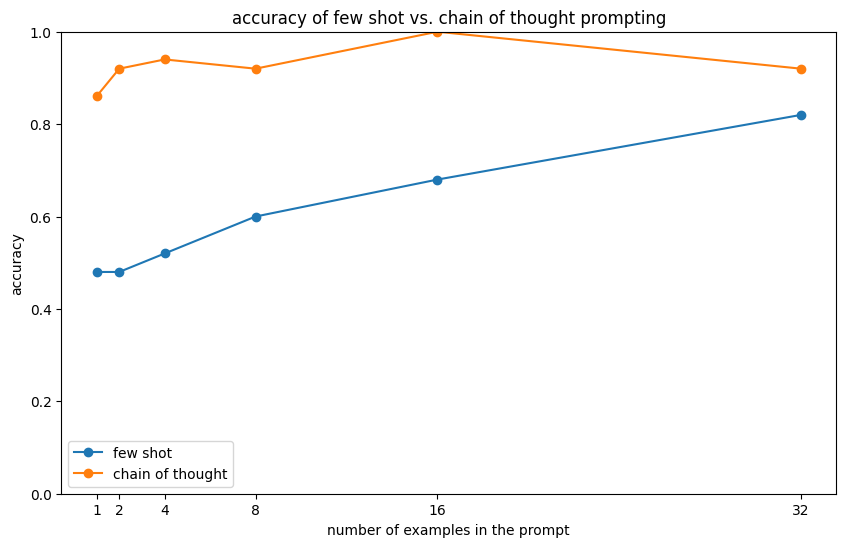

In [ ]:
import matplotlib.pyplot as plt

few_shot_x, few_shot_y = zip(*few_shot_results)
cot_x, cot_y = zip(*cot_results)

plt.figure(figsize=(10, 6))
plt.plot(few_shot_x, few_shot_y, label='few shot', marker='o')
plt.plot(cot_x, cot_y, label='chain of thought', marker='o')

plt.title("accuracy of few shot vs. chain of thought prompting")
plt.xlabel("number of examples in the prompt")
plt.ylabel("accuracy")
plt.legend()
plt.xticks(few_shot_x)
plt.ylim(0, 1)

plt.show()

Using chain-of-thought prompting generally produces a higher accuracy than using few-shot only. This suggests that providing explanation and reasoning allows the model to learn how we got to the correct solution, then mimic the same pattern. We can see also that for few-shot prompting, the performance is pretty poor with just 1-2 examples since all we are providing is the input expression and the output value. This increases with more examples in the prompt, but only ever gets to around 80% accuracy even with 32 examples. For chain-of-thought prompting, the accuracy already begins at 86% with just one example with structured reasoning. This increases all the way up to 100% accuracy at one point with 16 examples in the prompt. However, we do see diminishing returns by the time we hit 8 examples as well as a few dips back to 92% accuracy, which could just be due to the fact that the examples in the prompt are generated randomly. Overall, chain-of-thought prompting still outperforms few-shot alone by showing the model how to think, at any number of examples used.
